In [1]:
import os
import zipfile
import rasterio
import requests

import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

!pip install -q censusdata

## Land Cover Data

In [2]:
url = "https://earthobs3.arcgis.com/arcgis/rest/directories/arcgisoutput/ESA_CCI_Land_Cover_Time_Series_ImageServer/x_____xgzxEgmG5T4d90R8b7G3-5g..x_____x_ags_2de165c0_1280_4fbd_a737_a49d53892adf.tif"
output_file = "./Data/spokane_landcover.tif"

response = requests.get(url, stream=True)

if response.status_code == 200:
    with open(output_file, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"File saved yayyy")
else:
    print("Download failed:", response.status_code)

Download failed: 400


In [3]:
land_use_fn = "./Data/spokane_landcover.tif"

proj_fn = os.path.splitext(land_use_fn)[0]+'_utm_gdalwarp.tif'
dst_crs = 'EPSG:4326'

In [4]:
!gdalwarp -srcnodata 0 -t_srs $dst_crs $land_use_fn $proj_fn

Processing ./Data/spokane_landcover.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [5]:
land_use_da = rxr.open_rasterio(land_use_fn).squeeze()

In [6]:
#land_use_da.plot.imshow(cmap='inferno')

## Radiation Data

In [7]:
# Define the ImageServer exportImage URL
server_url = "https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_MONTHLY_RADIATION_UTC/ImageServer/exportImage"

# Define parameters for exporting an image
params = {
    "bbox": "-117.823629,47.259272,-117.039763,48.047877,53063",  # Bounding box covering Spokane County
    "bboxSR": "4326",
    "imageSR": "4326",
    "size": "4000,4000",  # Resolution of the image
    "format": "tiff",  # Use "png" if you prefer a simple image
    "f": "json",
}

# Request the image
response = requests.get(server_url, params=params)

if response.status_code == 200:
    image_data = response.json()
    image_url = image_data.get("href", None)  # Extract image URL

    if image_url:
        print(f"Downloading image from: {image_url}")

        # Download the raster image
        image_response = requests.get(image_url)
        image_filename = "Data/radiation.tif"

        with open(image_filename, "wb") as file:
            file.write(image_response.content)

        print(f"Image saved")
    else:
        print("No image URL found in response.")
else:
    print(f"Failed to fetch data: {response.status_code}, Response: {response.text}")

Image saved


In [8]:
radiation_fn = "./Data/radiation.tif"

proj_fn = os.path.splitext(land_use_fn)[0]+'_utm_gdalwarp.tif'
dst_crs = 'EPSG:4326'

In [9]:
!gdalwarp -srcnodata 0 -t_srs $dst_crs $radiation_fn $proj_fn

Processing ./Data/radiation.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
radiation_da = rxr.open_rasterio(radiation_fn).squeeze()

In [11]:
#radiation_da.plot.imshow()

## Parks & Protected Lands GDF

In [12]:
zipped = "./Data/ne_10m_parks_and_protected_lands.zip"  # Adjust filename
path = "./Data/parks_data"

# Extract the files
with zipfile.ZipFile(zipped, 'r') as zip_ref:
    zip_ref.extractall(path)

print("Files extracted yESSSSSSS!")

Files extracted yESSSSSSS!


In [13]:
import geopandas as gpd

shp_path = os.path.join(path, "ne_10m_parks_and_protected_lands_area.shp")  # Adjust filename
parks_gdf = gpd.read_file(shp_path)

display(parks_gdf.head())

,unit_code,unit_name,unit_type,nps_region,scalerank,featurecla,note,name,geometry
0,HAVO,Hawai'i Volcanoes NP,National Park,Pacific West,3,National Park Service,None,Hawai'i Volcanoes,"POLYGON ((-155.05872 19.36694, -155.04423 19.3..."
1,CANA,Canaveral NS,National Seashore,Southeast,5,National Park Service,None,Canaveral NS,"POLYGON ((-80.62708 28.65088, -80.69853 28.643..."
2,SAMO,Santa Monica Mountains NRA,National Recreation Area,Pacific West,8,National Park Service,None,Santa Monica Mountains,"POLYGON ((-118.43156 34.13367, -118.36393 34.1..."
3,CHIS,Channel Islands NP,National Park,Pacific West,5,National Park Service,None,Channel Islands,"MULTIPOLYGON (((-119.02896 33.48394, -119.0288..."
4,PORE,Point Reyes NS,National Seashore,Pacific West,5,National Park Service,None,Point Reyes,"POLYGON ((-122.71476 37.95817, -122.72445 37.9..."


In [14]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)
WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

In [15]:
#Code taken from lab 5
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]

In [16]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
'B27001_005E': 'PopulationNoHealthInsuranceCoverage',
}

In [17]:
import censusdata
import shutil

state_fips = '53'  # FIPS code for Washington
county_fips = '063'  # FIPS code for Spokane County

census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)

census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')

In [18]:
parks_gdf

,unit_code,unit_name,unit_type,nps_region,scalerank,featurecla,note,name,geometry
0,HAVO,Hawai'i Volcanoes NP,National Park,Pacific West,3,National Park Service,None,Hawai'i Volcanoes,"POLYGON ((-155.05872 19.36694, -155.04423 19.3..."
1,CANA,Canaveral NS,National Seashore,Southeast,5,National Park Service,None,Canaveral NS,"POLYGON ((-80.62708 28.65088, -80.69853 28.643..."
2,SAMO,Santa Monica Mountains NRA,National Recreation Area,Pacific West,8,National Park Service,None,Santa Monica Mountains,"POLYGON ((-118.43156 34.13367, -118.36393 34.1..."
3,CHIS,Channel Islands NP,National Park,Pacific West,5,National Park Service,None,Channel Islands,"MULTIPOLYGON (((-119.02896 33.48394, -119.0288..."
4,PORE,Point Reyes NS,National Seashore,Pacific West,5,National Park Service,None,Point Reyes,"POLYGON ((-122.71476 37.95817, -122.72445 37.9..."
...,...,...,...,...,...,...,...,...,...
56,GRCA,Grand Canyon NP,National Park,Intermountain,3,National Park Service,None,Grand Canyon,"POLYGON ((-111.63245 36.81852, -111.64364 36.7..."
57,GLCA,Glen Canyon NRA,National Recreation Area,Intermountain,4,National Park Service,None,Glen Canyon NRA,"POLYGON ((-110.00028 37.26143, -110.00028 37.2..."
58,GAAR,Gates of the Arctic NP & PRES,National Park and Preserve,Alaska,3,National Park Service,None,Gates of the Arctic,"MULTIPOLYGON (((-152.94364 68.56856, -153.0073..."
59,DENA,Denali NP & PRES,National Park and Preserve,Alaska,3,National Park Service,None,Denali,"POLYGON ((-148.80318 63.63721, -148.80318 63.6..."


In [19]:
washington_gdf = parks_gdf[parks_gdf["nps_region"] == "Intermountain"]
washington_gdf

,unit_code,unit_name,unit_type,nps_region,scalerank,featurecla,note,name,geometry
10,ZION,Zion NP,National Park,Intermountain,3,National Park Service,None,Zion,"POLYGON ((-113.01351 37.17106, -113.09078 37.1..."
11,PEFO,Petrified Forest NP,National Park,Intermountain,3,National Park Service,None,Petrified Forest,"POLYGON ((-109.86023 35.17188, -109.6864 35.17..."
12,GRTE,Grand Teton NP,National Park,Intermountain,3,National Park Service,None,Grand Teton,"POLYGON ((-110.79704 44.08602, -110.79704 44.0..."
18,YELL,Yellowstone NP,National Park,Intermountain,3,National Park Service,None,Yellowstone,"POLYGON ((-111.09644 44.48686, -111.09644 45.0..."
20,WHSA,White Sands NM,National Monument,Intermountain,5,National Park Service,None,White Sands NM,"MULTIPOLYGON (((-106.17098 32.77193, -106.1564..."
21,ORPI,Organ Pipe Cactus NM,National Monument,Intermountain,5,National Park Service,None,Organ Pipe Cactus NM,"POLYGON ((-113.08594 31.96338, -113.08594 32.2..."
22,GRSA,Great Sand Dunes NP & PRES,National Park and Preserve,Intermountain,5,National Park Service,None,Great Sand Dunes,"POLYGON ((-105.53353 37.95333, -105.53353 37.9..."
26,ROMO,Rocky Mountain NP,National Park,Intermountain,3,National Park Service,None,Rocky Mountain,"POLYGON ((-105.53353 40.30017, -105.56254 40.2..."
31,ELMA,El Malpais NM,National Monument,Intermountain,5,National Park Service,None,El Malpais NM,"POLYGON ((-107.80314 34.98356, -107.82243 34.9..."
32,DINO,Dinosaur NM,National Monument,Intermountain,4,National Park Service,None,Dinosaur NM,"POLYGON ((-108.53687 40.44019, -108.53687 40.4..."


In [20]:
parks_gdf["nps_region"]

0      Pacific West
1         Southeast
2      Pacific West
3      Pacific West
4      Pacific West
          ...      
56    Intermountain
57    Intermountain
58           Alaska
59           Alaska
60    Intermountain
Name: nps_region, Length: 61, dtype: object

In [21]:
hull = tract_geom_gdf.geometry.unary_union

parks_gdf.clip(hull)

/tmp/ipykernel_2010/1795903500.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = tract_geom_gdf.geometry.unary_union


,unit_code,unit_name,unit_type,nps_region,scalerank,featurecla,note,name,geometry


<Axes: >

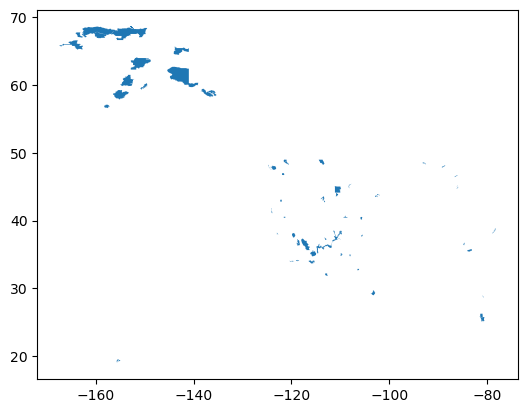

In [22]:
parks_gdf.plot()

In [23]:
census_Spokane_gdf = census_Spokane_gdf.to_crs(parks_gdf.crs)
census_clipped_gdf = census_Spokane_gdf.overlay(parks_gdf, how='difference')

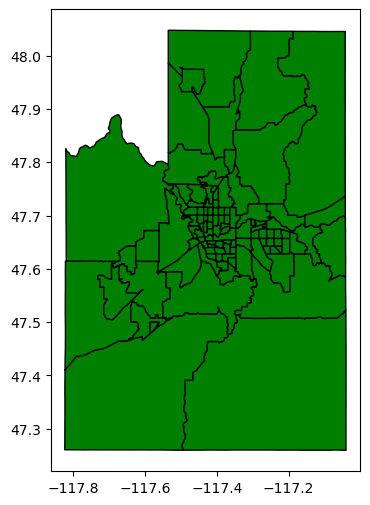

In [24]:
fig, ax = plt.subplots(figsize=(9,6))

census_clipped_gdf.plot(ax=ax, color="green", edgecolor='black')

plt.show()